# kerasまとめ
- backend
    - backend(): 'tensorflow'など，バックエンドのエンジン名を返す
    - tensorflow_backend
        - set_session: configなどを設定したsessionを設定

### tensorflow as tf
- ConfigProto()
    - gpu_options
    - per_process_gpu_memory_fraction: 0~1までのGPU使用割合
    - allow_growth: Trueなら使用量に応じてGPUメモリを確保していく
- Session()
    - config: ConfigProtによるconfigオブジェクトをsessionに変換- 
- get_default_graph()
    - as_default(): このwithで囲んだコードはdefault sessionで実行される
        - flask内のリクエスト等，別sessionで実行されてしまうときに使う


# やること
- 囲碁ボットのアプリケーション，HTTPフロントエンドの作成  
- ボット同士の対局
- AWSにボットを配置しオンライン囲碁サーバに接続

## 深層NNによる着手予測エージェントの作成
[dlgo/kerasutil.py](https://github.com/maxpumperla/deep_learning_and_the_game_of_go/blob/master/code/dlgo/kerasutil.py)を作成  
ここにはset_gpu_memory_target(frac)が含まれている  
こいつは例えばfrac=0.5とすると使用可能なGPUのメモリの50%のみを確保する  
さらに，allow_growth=Trueをtf.GPUOptionsのとこに書き足す．  
これにより，必要な分だけGPUのメモリを確保していく  
  
これらのオプションはtensorflowを使っている時のみ有効なので，importはバックエンドの確認を行なった後に行う．

メモリについての参考  
[per_process_gpu_memory_fractionオプション](https://qiita.com/ballforest/items/3f21bcf34cba8f048f1e)  
[allow_growthオプション](https://blog.amedama.jp/entry/2017/06/07/220723)

dlgo/agent/predict.pyを作成  
- DeepLeaningAgent(model, encoder)
    - predict: 渡したGameStateから次の手を予測
    - select_move: predictの結果から確率分布を作り，それに従った手を打つ
    - serialize: インスタンスの持つモデルとメタ情報をhdf5で保存
- load_prediction_agent(h5file)
    - HDF5ファイルからDeepLeaningAgentをデシリアライズ
    
ここで永続化に使用されている[h5py](https://qiita.com/aoksh/items/cd124183f38e19def731)の使い方
- with h5py.File('path/to/file.h5', 'w') as h5fileの中で
    - h5file.create_group(name)でグループを作る
    - h5file[name].attrsという辞書に保存したいデータを入れていく
    
modelは重いからか，[tempfile](https://qiita.com/everylittle/items/aa7c6f612ff0a9db7f01)というモジュールで保存と読み込みが行われている

## 囲碁ボットのWebフロントエンドへの提供
flask + jgoboard(JSライブラリ)でブラウザ囲碁UIを作成
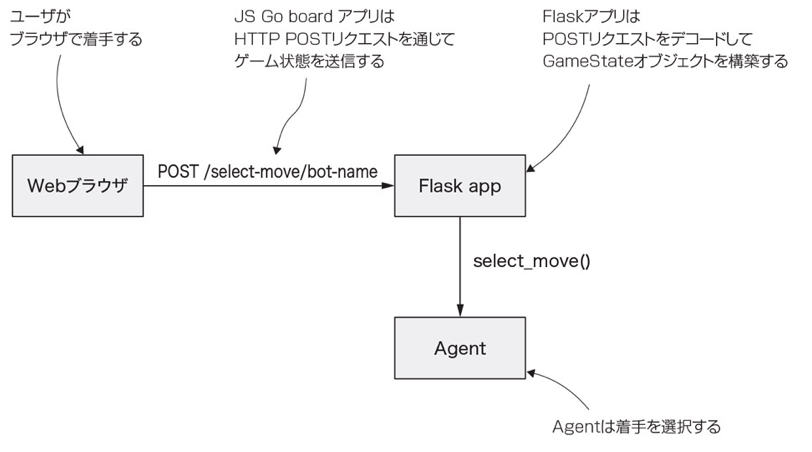

[dlgo/httpfrontend](https://github.com/maxpumperla/deep_learning_and_the_game_of_go/tree/master/code/dlgo/httpfrontend)モジュールをもらってくる  
[svnによってディレクトリをダウンロード](https://qiita.com/raucha/items/1219327df8a9ded494df)

Macの例
``` bash
$ brew install svn
$ cd path/to/dlgo
$ svn export https://github.com/maxpumperla/deep_learning_and_the_game_of_go/trunk/code/dlgo/httpfrontend
$ pip install flask
```

#### 注意すること
server.pyの `'diagnostics': bot_agent.diagnostics()`をコメントアウト  
  
あと，flaskの各リクエストでは，tensorflowセッションを新たに作ってしまう．  
モデルはdefaultセッションにロードされるが別セッションでは正しく動かない  
これを避けるため[参考](https://kobkrit.com/tensor-something-is-not-an-element-of-this-graph-error-in-keras-on-flask-web-server-4173a8fe15e1)に従い，select_moveに`with graph.as_default():`をかける
  
なぜかdlgo/util.pyになかったcoords_from_point()を作成  
  
説明して欲しかったんだけど，囲碁では1とIを区別するため，Iを飛ばす．  
このアルファベットの取り扱い方はJGoBoardでも利用されている．  
そのため，実はutil.pyのCOLSにもIが入ってなかった．  
  
あと，間違えて着手したときパスになるのはよくない．  
(なんかエラー発生することもあるし)  
なので，JavaScriptのapplyMoveでreturn play.successを行う．  
さらにcreateのclickListenerではif (!applyMove(...)) return;とする

トップに次のようなplay.pyを作成  

In [ ]:
import argparse
from dlgo.httpfrontend.server import get_web_app

parser = argparse.ArgumentParser()
parser.add_argument('-a', '--agent')
args = parser.parse_args()

agent_name = args.agent

if agent_name == "predict":
    
    from dlgo.agent.predict import DeepLearningAgent
    from dlgo.encoders.oneplane import OnePlaneEncoder
    from keras.models import load_model
    
    encoder = OnePlaneEncoder(19)
    model = load_model("../datasets/dlgo/checkpoints/small_model_epoch_5.h5")
    web_app = get_web_app({'predict': DeepLearningAgent(model, encoder)})

else:
    from dlgo.agent.naive import RandomBot
    web_app = get_web_app({'random': RandomBot()})

web_app.run()

play.pyを実行し，APIサーバを起動    
``` bash
$ python play.py
```
続いて，以下にアクセスするとランダムエージェントと囲碁で遊べる  
http://localhost:5000/static/play_random_99.html  

DeepLearningAgentと遊ぶには，
``` bash
$ python play.py -a=predict
```
http://localhost:5000/static/play_predict_19.html  
しかし相変わらずランダムと大して変わらない．学習できてないモデルなのでは？

### エンドツーエンドな囲碁ボットの例
ここまでのまとめみたいなコード．特に書かなくていいかと．  
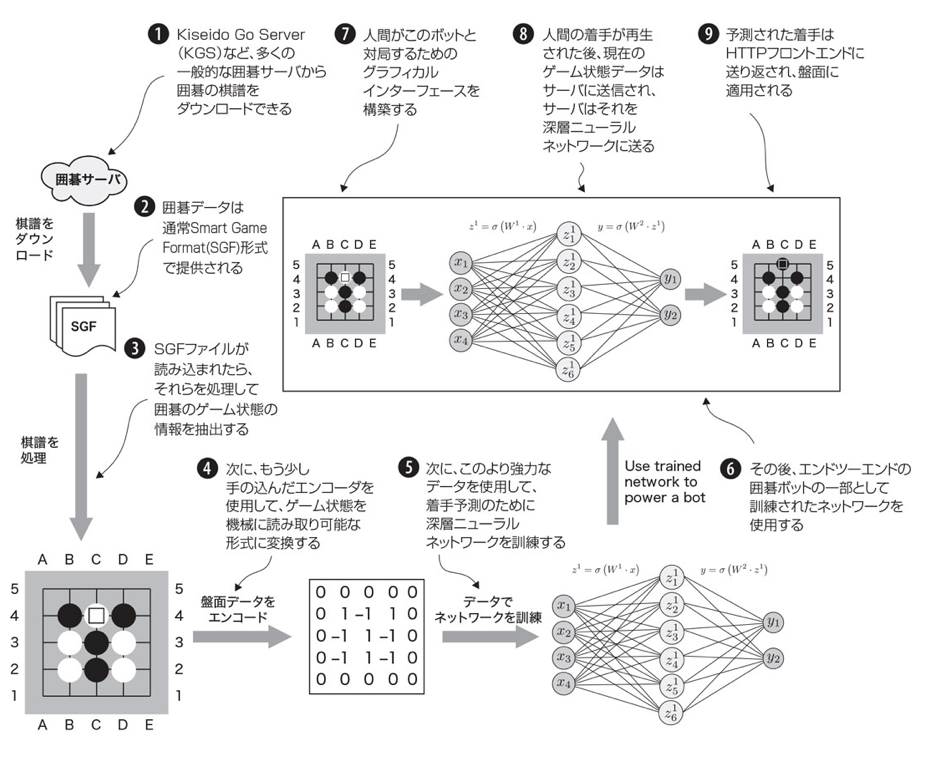

## 囲碁ボットのクラウドへの配置と訓練
上記のアプリケーションをAWSでホスティングする．  
これは付録Dで行う．

## 他のボットとの対話 Go Text Protocol (GTP)
囲碁の着手データをやり取りするためのプロトコル，GTPが存在する．  
付録Cに従い，「GNU Go」と「Pachi」をインストールする  

# 付録C 囲碁プログラムとサーバ
## GNU Go
1989に開発されたルールベースの強力な囲碁エンジン  
[ダウンロード先](http://www.gnu.org/software/gnugo/download.html)

[CLI版](http://ftp.gnu.org/gnu/gnugo/)をまずはインストールして  
グラフィカルインタフェース版も入れる  
Win: [JagoClient](http://www.rene-grothmann.de/jago/)  
Mac: [FreeGoban](http://www.sente.ch/software/goban/freegoban.html#Download)